# Risk-Stratified SHAP Networks

This notebook implements risk-stratified aggregation of SHAP values to identify different feature importance patterns across risk subgroups.

**Approach:** Stratify patients by predicted disease risk (low/medium/high) and build separate networks for each group. This reveals how feature importance varies across risk levels.

In [1]:
import os
import sys
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cgt_perezsechi.visualization.graph import draw
from cgt_perezsechi.manipulation.norm import normalize_psi, normalize_r

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configure matplotlib for VS Code Jupyter
%matplotlib inline

In [3]:
# Load data
X = pd.read_pickle("../data/x_values.pkl")
num_patients = 500
X_shapley = X.iloc[:num_patients, :]
shap_values = np.load("../data/shap_values.npy")
shap_interaction_values = np.load("../data/shap_interaction_values.npy")

# Load y values (outcome/risk) from NHANES dataset
_, y = shap.datasets.nhanesi()
y_shapley = y[:num_patients]

## Stratify Patients by Actual Risk (y variable)

Use the actual outcome variable (y) to stratify patients into risk groups

In [23]:
from math import ceil

# Use actual outcome variable (y) for risk stratification
shap_values_clean = np.nan_to_num(shap_values)

# Stratify based on y values (actual disease outcome/risk)
# Sort and create tertiles based on y
sorted_indices = np.argsort(y_shapley)
n_low_risk = ceil(len(y_shapley) * 0.66)

low_risk_indices = sorted_indices[:n_low_risk]
high_risk_indices = sorted_indices[n_low_risk:]

# Create masks
low_risk_mask = np.isin(np.arange(len(y_shapley)), low_risk_indices)
high_risk_mask = np.isin(np.arange(len(y_shapley)), high_risk_indices)

# Display statistics
print(f"Risk stratification based on outcome variable (y):\n")
print(f"Low risk patients: {low_risk_mask.sum()}")
print(f"  y range: [{y_shapley[low_risk_indices].min():.4f}, {y_shapley[low_risk_indices].max():.4f}]")
print(f"  y mean: {y_shapley[low_risk_indices].mean():.4f}")

print(f"\nHigh risk patients: {high_risk_mask.sum()}")
print(f"  y range: [{y_shapley[high_risk_indices].min():.4f}, {y_shapley[high_risk_indices].max():.4f}]")
print(f"  y mean: {y_shapley[high_risk_indices].mean():.4f}")

Risk stratification based on outcome variable (y):

Low risk patients: 330
  y range: [-22.0833, -12.2500]
  y mean: -20.5359

High risk patients: 170
  y range: [-11.8333, 21.4167]
  y mean: 10.4657


## Function to Build Network for Risk Stratum

In [24]:
def build_network_for_stratum(patient_mask, shap_values, shap_interaction_values, X_shapley):
    """
    Build psi and r matrices for a specific patient stratum
    """
    # Filter SHAP values for this stratum
    stratum_shap = shap_values[patient_mask]
    stratum_interaction = shap_interaction_values[patient_mask]
    
    # Calculate psi_1 (node weights)
    sum_shap = np.sum(np.abs(stratum_shap), axis=(0, 1))
    psi_1 = pd.DataFrame()
    psi_1['value'] = np.sum(stratum_shap, axis=0) / sum_shap
    psi_1.set_index(X_shapley.columns, inplace=True)
    
    # Calculate r_1 (edge weights) - remove diagonal
    n_patients_stratum = stratum_interaction.shape[0]
    n_variables = stratum_interaction.shape[1]
    
    filtered_interaction = np.nan_to_num(stratum_interaction.copy())
    idx_patients = np.repeat(np.arange(n_patients_stratum), n_variables)
    idx_variables = np.tile(np.arange(n_variables), n_patients_stratum)
    filtered_interaction[idx_patients, idx_variables, idx_variables] = 0
    
    sum_interaction = np.sum(filtered_interaction, axis=(0, 1, 2))
    cumulative_interaction = np.sum(filtered_interaction, axis=0)
    
    r_1 = pd.DataFrame(cumulative_interaction / sum_interaction)
    r_1.rename(columns=dict(list(zip(r_1.columns, X_shapley.columns))), inplace=True)
    r_1.set_index(X_shapley.columns, inplace=True)
    
    # Normalize
    psi_2 = normalize_psi(psi_1)
    r_2 = normalize_r(r_1)
    
    return psi_1, r_1, psi_2, r_2

## Build Networks for Each Risk Stratum

In [25]:
# Build networks for each stratum
low_psi_1, low_r_1, low_psi_2, low_r_2 = build_network_for_stratum(
    low_risk_mask, shap_values_clean, shap_interaction_values, X_shapley
)

high_psi_1, high_r_1, high_psi_2, high_r_2 = build_network_for_stratum(
    high_risk_mask, shap_values_clean, shap_interaction_values, X_shapley
)

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_edge_width = r.applymap(lambda x: abs(x)).max().max()
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(lambda x: x / max_edge_width)
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_edge_width = r.applymap(lambda x: abs(x)).max().max()
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(lambda x: x / max_edge_width)


## Visualization Setup

In [30]:
shap_cmap = shap.plots.colors.red_blue
positive_color = shap_cmap(0.0)[:3]
negative_color = shap_cmap(1.0)[:3]

positive_alpha = 0.01
negative_alpha = 0.01
positive_beta = 0
negative_beta = 0

## Low Risk Network

Low Risk Patients Network


c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\visualization\graph.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(filter_edge)
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\visualization\graph.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  adjacency = r.copy().applymap(lambda x: 1 if x != 0 else 0)


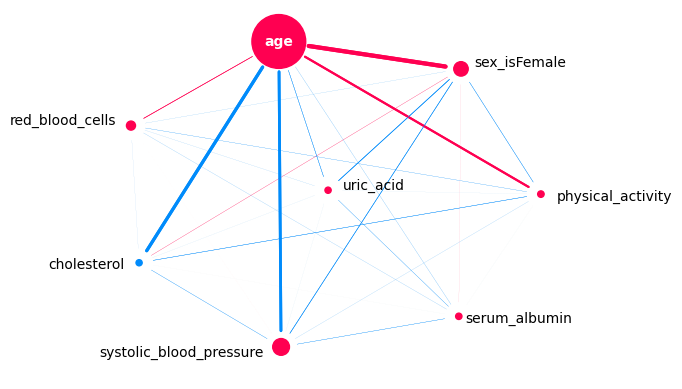

In [31]:
print("Low Risk Patients Network")
draw(
    psi=low_psi_2,
    r=low_r_2,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
)

## High Risk Network

High Risk Patients Network


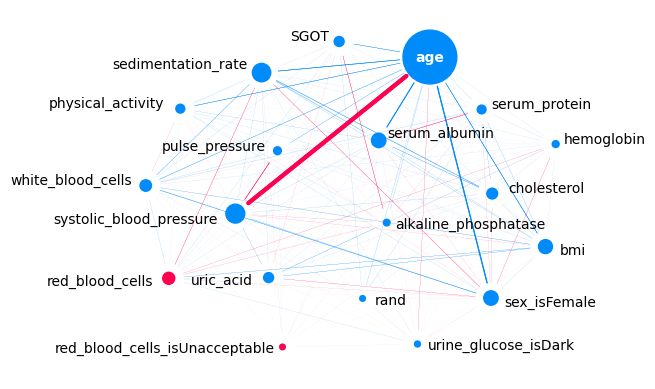

In [37]:
print("High Risk Patients Network")
draw(
    psi=high_psi_2,
    r=high_r_2,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
)

## Comparative Analysis

Compare top features across risk strata

In [33]:
# Compare top features by risk stratum
def get_top_features(psi, n=10):
    return psi['value'].abs().nlargest(n)

print("Top 10 Features by Risk Stratum:\n")
print("LOW RISK:")
print(get_top_features(low_psi_1))
print("\nHIGH RISK:")
print(get_top_features(high_psi_1))

Top 10 Features by Risk Stratum:

LOW RISK:
age                        1.000000
systolic_blood_pressure    0.096998
sex_isFemale               0.072120
red_blood_cells            0.028375
physical_activity          0.014489
serum_albumin              0.013816
uric_acid                  0.013372
cholesterol                0.013099
sedimentation_rate         0.009396
hematocrit                 0.008777
Name: value, dtype: float64

HIGH RISK:
age                        1.000000
systolic_blood_pressure    0.123242
sedimentation_rate         0.116663
sex_isFemale               0.071728
serum_albumin              0.071593
bmi                        0.067287
red_blood_cells            0.049831
white_blood_cells          0.045408
cholesterol                0.040321
uric_acid                  0.034383
Name: value, dtype: float64
